In [1]:
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
import pandas as pd
import mne
data_dir = 'data_meg'
subj = "R2487"
dataqual = 'prepro' #or loc/exp
exp = 'exp' #or exp
dtype = "raw"
label_dir = 'data_log'
save_dir = 'data_meg'



In [2]:
raw = mne.io.read_raw_fif(f'{data_dir}/{subj}/{dataqual}/{subj}_{exp}.fif', preload=True)

Opening raw data file data_meg/R2487/prepro/R2487_exp.fif...


/var/folders/79/m99pb_8d67l3d79st4zhf4tc0000gn/T/ipykernel_49791/1914332943.py:1: RuntimeWarning: This filename (data_meg/R2487/prepro/R2487_exp.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(f'{data_dir}/{subj}/{dataqual}/{subj}_{exp}.fif', preload=True)


    Range : 0 ... 2779999 =      0.000 ...  2779.999 secs
Ready.
Opening raw data file /Users/dorisyu/meg_decoding/data_meg/R2487/prepro/R2487_exp-1.fif...
    Range : 2780000 ... 3074999 =   2780.000 ...  3074.999 secs
Ready.
Reading 0 ... 3074999  =      0.000 ...  3074.999 secs...


In [3]:
sfreq = raw.info['sfreq']
raw.filter(1, 40, method='iir')

downsample = 10

Filtering raw data in 2 contiguous segments
Setting up band-pass filter from 1 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 40.00 Hz: -6.02, -6.02 dB



In [15]:
events = mne.find_events(raw, stim_channel='STI 014', output='onset', shortest_event=1)
event_id = {
    'start': 160,
    'move': 161,
    'reveal_red': 162,
    'reveal_white': 163,
    'done': 164,
    'choice': 165,
    'timeout': 166
}

# Define trials to remove
trials_to_remove = []

4629 events found on stim channel STI 014
Event IDs: [160 161 162 163 164]


In [20]:
start_events = events[events[:, 2] == event_id['start']]
done_events = events[events[:, 2] == event_id['done']]
timeout_events = events[events[:, 2] == event_id['timeout']]
reveal_red_events = events[events[:, 2] == event_id['reveal_red']]
reveal_white_events = events[events[:, 2] == event_id['reveal_white']]
sfreq = raw.info['sfreq']  # Sampling frequency

# Combine 'done' and 'timeout' events
end_events = np.concatenate((done_events, timeout_events))
end_events = end_events[end_events[:, 0].argsort()]  # Sort by time

# Initialize a list to store trial information
trial_info = []
previous_start_sample = None
processed_starts = set()
start_idx = 0
trail_t = 21
# Iterate through each start event to create trial information
for idx, start_event in enumerate(start_events):
    start_sample = start_event[0]
    
    # Find the next end event after the start event
    end_idx = np.searchsorted(end_events[:, 0], start_sample, side='right')
    end_sample = None
    while end_idx < len(end_events):
        potential_end_sample = end_events[end_idx, 0]
        if (potential_end_sample - start_sample) / sfreq <= trail_t:
            end_sample = potential_end_sample
            break
        end_idx += 1

    # If no valid end event is found, set end_sample to 26 seconds after start_sample
    if end_sample is None:
        end_sample = start_sample + int(trail_t * sfreq)

    # Check if the current start is at least 20 seconds after the previous start
    if (previous_start_sample is None or (start_sample - previous_start_sample) / sfreq >= 20) and start_sample not in processed_starts:
        # Proceed with processing this start event
        previous_start_sample = start_sample
        processed_starts.add(start_sample)  # Add to the set of processed starts

        # Calculate tmin and tmax for the epoch
        tmin = -0.2  # 0.2 s before 'start'
        tmax = trail_t  # Duration from 'start' to 1 s after end event
        reveal_red_within_trial = reveal_red_events[(reveal_red_events[:, 0] > start_sample) & 
                                                    (reveal_red_events[:, 0] < end_sample)]
        reveal_white_within_trial = reveal_white_events[(reveal_white_events[:, 0] > start_sample) & 
                                                        (reveal_white_events[:, 0] < end_sample)]
        # Store trial information, including whether 'reveal_red' and 'reveal_white' occurred
        trial_info.append({
            'event_sample': start_sample,
            'trial_index': start_idx,
            'duration': tmax,
            'tmin': tmin,
            'tmax': trail_t,
            'done': len(done_events) > 0,
            'start_times': start_sample / sfreq,
            'done_times': end_sample / sfreq,
            'reveal_red': len(reveal_red_within_trial) > 0,  # Boolean flag indicating if 'reveal_red' occurred
            'reveal_red_times': (reveal_red_within_trial[:, 0] - start_sample) / sfreq if len(reveal_red_within_trial) > 0 else [],
            'reveal_white': len(reveal_white_within_trial) > 0,  # Boolean flag indicating if 'reveal_white' occurred
            'reveal_white_times': (reveal_white_within_trial[:, 0] - start_sample) / sfreq if len(reveal_white_within_trial) > 0 else [],
            'reveal_times': sorted(
                ((reveal_red_within_trial[:, 0] - start_sample) / sfreq).tolist() +
                ((reveal_white_within_trial[:, 0] - start_sample) / sfreq).tolist()
            )
        })
        start_idx += 1

tmax is 26
end sample is 84.544
tmax is 26
end sample is 118.862
tmax is 26
end sample is 143.857
tmax is 26
end sample is 168.89
tmax is 26
end sample is 193.924
tmax is 26
end sample is 202.829
tmax is 26
end sample is 231.243
tmax is 26
end sample is 260.41
tmax is 26
end sample is 285.391
tmax is 26
end sample is 299.787
tmax is 26
end sample is 321.146
tmax is 26
end sample is 339.693
tmax is 26
end sample is 370.048
tmax is 26
end sample is 387.995
tmax is 26
end sample is 424.468
tmax is 26
end sample is 434.16
tmax is 26
end sample is 470.135
tmax is 26
end sample is 479.823
tmax is 26
end sample is 515.83
tmax is 26
end sample is 525.054
tmax is 26
end sample is 541.086
tmax is 26
end sample is 565.167
tmax is 26
end sample is 602.806
tmax is 26
end sample is 627.812
tmax is 26
end sample is 667.771
tmax is 26
end sample is 671.426
tmax is 26
end sample is 713.325
tmax is 26
end sample is 719.939
tmax is 26
end sample is 758.952
tmax is 26
end sample is 769.336
tmax is 26
end 

In [8]:
new_events = np.array([[info['event_sample'], 0, event_id['start']] for info in trial_info])
tmin = -0.2  
# Initialize lists to store individual epochs data and trial information
epochs_data_list = []
trial_info_valid = []

In [9]:
# Iterate over new_events and create epochs, skipping the unwanted trials
for idx, event in enumerate(new_events):
    start_sample = event[0]
    event_id_code = event[2]
    event_time = start_sample / sfreq
    total_duration = raw.times[-1]
    print(f"Tmax is {tmax}")
    # Create the epoch
    epochs = mne.Epochs(
        raw, [event], event_id={f'event_{event_id_code}': event_id_code},
        tmin=tmin, tmax=tmax, preload=True,
        reject_by_annotation=False, reject=None, verbose=True
    )

    # Append valid epochs to the list
    if len(epochs) > 0:
        epochs_data_list.append(epochs.get_data()[:, :, ::downsample])
        trial_info_valid.append(trial_info[idx])
    else:
        print(f"Epoch {idx} was dropped.")
        print(f"Drop log for Epoch {idx}: {epochs.drop_log}")


Tmax is 30.103
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 30304 original time points ...
0 bad epochs dropped
Tmax is 30.103
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 30304 original time points ...
0 bad epochs dropped
Tmax is 30.103
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 30304 original time points ...
0 bad epochs dropped
Tmax is 30.103
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using d

In [10]:
len(epochs_data_list)

120

## Decoding

In [11]:
from mne.decoding import SlidingEstimator, cross_val_multiscore, Vectorizer
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler 
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from matplotlib import pyplot as plt
label_encoder = LabelEncoder()
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score


In [12]:
labels_df = pd.read_csv(f'{label_dir}/{subj}/label.csv')

# Step 1: Get the valid trial indices
valid_trial_indices = {info['trial_index'] for info in trial_info_valid}

# Step 2: Filter labels_df to only include valid trial indices
labels_df_filtered = labels_df[labels_df['trial_index'].isin(valid_trial_indices)]
label_dict = dict(zip(labels_df_filtered['trial_index'], labels_df_filtered['trial.rule']))

# Step 3: Extract labels for the valid trials in trial_info_valid
y_labels = []
for info in trial_info_valid:
    idx = info['trial_index']
    if idx in label_dict:
        y_labels.append(label_dict[idx])

timeout_true_indices = labels_df[labels_df['timeout'] == True]['trial_index'].values
timeout_false_indices = labels_df[labels_df['timeout'] == False]['trial_index'].values


# Convert labels to integers using label encoder
y = label_encoder.fit_transform(y_labels)

# Print the number of labels and valid trials after matching
n_labels = len(y_labels)
n_trials = len(trial_info_valid)
print(f"Number of labels after matching: {n_labels}")
print(f"Number of valid trials after matching: {n_trials}")


Number of labels after matching: 120
Number of valid trials after matching: 120


In [38]:
def extract_reveal(trial_info_valid, raw, label_dict, event_name='reveal_red', n_points_before=50, n_points_after=50, num_events=4):
    y_labels = []
    X_reveal = []
    trial_indices = []
    sfreq = raw.info['sfreq']  # Sampling frequency

    for info in trial_info_valid:
        reveal_times = info[f'{event_name}_times']
        if len(reveal_times) >= num_events:
            trial_data = []

            for event_time in reveal_times[:num_events]:
                event_sample = int(event_time * sfreq)
                start_sample_before = event_sample - n_points_before
                end_sample_after = event_sample + n_points_after

                if start_sample_before >= 0 and end_sample_after <= raw.n_times:
                    epoch_data = raw.get_data(start=start_sample_before, stop=end_sample_after)
                    
                    # Ensure epoch_data is 3D
                    if epoch_data.ndim == 2:
                        epoch_data = np.expand_dims(epoch_data, axis=2)
                    
                    trial_data.append(epoch_data)

            if trial_data:
                # Check if all trial_data have the same shape
                trial_data_shapes = [data.shape for data in trial_data]
                if len(set(trial_data_shapes)) == 1:
                    trial_data_concatenated = np.concatenate(trial_data, axis=2)
                    X_reveal.append(trial_data_concatenated)
                    trial_index = info['trial_index']
                    if trial_index in label_dict:
                        y_labels.append(label_dict[trial_index])
                        trial_indices.append(trial_index)
                else:
                    print(f"Inconsistent shapes in trial data for trial index {info['trial_index']}: {trial_data_shapes}")

    return np.array(X_reveal), np.array(y_labels), trial_indices

def extract_start(trial_info, raw, label_dict, n_points_before=50, n_points_after=50):
    X_start = []
    y_labels = []
    trial_indices = []
    for info in trial_info:
        # Get the done sample from the trial information
        start_sample = info['event_sample'] + int((info['tmin'] + 0.2) * raw.info['sfreq'])

        # Calculate start and end samples for extraction
        start_sample_before = start_sample - n_points_before
        end_sample_after = start_sample + n_points_after

        # Ensure the samples are within bounds
        if start_sample_before >= 0 and end_sample_after <= raw.n_times:
            # Extract data for this trial
            epoch_data = raw.get_data(start=start_sample_before, stop=end_sample_after)
            X_start.append(epoch_data)
            trial_index = info['trial_index']
            if trial_index in label_dict:
                y_labels.append(label_dict[trial_index])
                trial_indices.append(trial_index)

    return  np.array(X_start), np.array(y_labels), trial_indices


def extract_done(trial_info, raw, label_dict, n_points_before=50, n_points_after=50):
    X_done = []
    y_labels = []
    trial_indices = []
    sfreq = raw.info['sfreq']  # Sampling frequency
    done_times = [info['done_times'] for info in trial_info]
    start_times = [info['start_times'] for info in trial_info]
    
    for info, done_time, start_time in zip(trial_info, done_times, start_times):
        # Check if the "done" event exists
        done_time = info['done_times'] 
        start_time = info['start_times']
        print(f"Trial_index: {info['trial_index']}, Done time: {done_time}, Start time: {start_time}")
        if int(done_time) - int(start_time) > 25:  # Assuming these indicate the presence of a "done" event
            done_sample = info['event_sample'] + int((info['tmax'] - 1.0) * sfreq)
            start_sample_before = done_sample - n_points_before
            end_sample_after = done_sample + n_points_after
        else:
            start_sample_before = int(done_time * sfreq) - n_points_before
            end_sample_after = int(done_time * sfreq) + n_points_after

        # Ensure the samples are within bounds
        if start_sample_before >= 0 and end_sample_after <= raw.n_times:
            epoch_data = raw.get_data(start=start_sample_before, stop=end_sample_after)
            X_done.append(epoch_data)
            trial_index = info['trial_index']
            if trial_index in label_dict:
                y_labels.append(label_dict[trial_index])
                trial_indices.append(trial_index)

    return np.array(X_done), np.array(y_labels), trial_indices


In [39]:
# Extract the first n_events reveal events
epoch_reveal, y_labels_reveal, trial_indices_reveal = extract_reveal(trial_info_valid, raw, label_dict, num_events=4)
epoch_start, y_labels_start, trial_indices_start = extract_start(trial_info_valid, raw, label_dict)
epoch_done, y_labels_done, trial_indices_done = extract_done(trial_info_valid, raw, label_dict)

# Find common trial indices across all epochs
common_trial_indices = set(trial_indices_reveal) & set(trial_indices_start) & set(trial_indices_done)

# Convert to a sorted list to maintain order
common_trial_indices = sorted(common_trial_indices)

# Function to filter epochs and labels based on common trial indices
def filter_by_trial_indices(epochs, labels, trial_indices, common_indices):
    mask = [i for i, idx in enumerate(trial_indices) if idx in common_indices]
    return epochs[mask], labels[mask]

# Filter each epoch and labels
epoch_start_filtered, y_labels_start_filtered = filter_by_trial_indices(epoch_start, y_labels_start, trial_indices_start, common_trial_indices)
epoch_reveal_filtered, y_labels_reveal_filtered = filter_by_trial_indices(epoch_reveal, y_labels_reveal, trial_indices_reveal, common_trial_indices)
epoch_done_filtered, y_labels_done_filtered = filter_by_trial_indices(epoch_done, y_labels_done, trial_indices_done, common_trial_indices)

# Flatten the reveal epoch to combine the event dimension into the time axis
n_trials, n_channels, n_timepoints_per_event, n_events = epoch_reveal_filtered.shape
epoch_reveal_flattened = epoch_reveal_filtered.reshape(n_trials, n_channels, n_timepoints_per_event * n_events)

# Check the new shape
print(f"Flattened epoch_reveal shape: {epoch_reveal_flattened.shape}")

# Combine the filtered epochs
X_combined = np.concatenate((epoch_start_filtered, epoch_reveal_flattened, epoch_done_filtered), axis=2)
print(f"Combined data shape: {X_combined.shape}")

# Use the labels from the first filtered epoch (assuming they are the same for all)
y_combined = y_labels_done_filtered

# Check the shape of the labels
print(f"Labels shape: {y_combined.shape}")

Trial_index: 0, Done time: 99.818, Start time: 90.448
Trial_index: 1, Done time: 135.957, Start time: 116.113
Trial_index: 2, Done time: 159.321, Start time: 141.954
Trial_index: 3, Done time: 196.923, Start time: 167.775
Trial_index: 4, Done time: 227.015, Start time: 197.907
Trial_index: 5, Done time: 244.415, Start time: 227.988
Trial_index: 6, Done time: 278.829, Start time: 253.783
Trial_index: 7, Done time: 295.074, Start time: 279.934
Trial_index: 8, Done time: 334.807, Start time: 305.721
Trial_index: 9, Done time: 340.54, Start time: 335.793
Trial_index: 10, Done time: 390.509, Start time: 361.378
Trial_index: 11, Done time: 409.353, Start time: 391.492
Trial_index: 12, Done time: 450.137, Start time: 421.037
Trial_index: 13, Done time: 472.447, Start time: 451.121
Trial_index: 14, Done time: 482.597, Start time: 477.018
Trial_index: 15, Done time: 531.748, Start time: 502.617
Trial_index: 16, Done time: 541.159, Start time: 532.731
Trial_index: 17, Done time: 571.606, Start t

# Cross-validation

In [40]:
from scipy.ndimage import gaussian_filter1d
def smooth_scores(scores, sigma=2):
    return gaussian_filter1d(scores, sigma=sigma)

def evaluate_model(y_true, y_pred, class_names):
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Print confusion matrix
    print("Confusion Matrix:")
    print(cm)
    
    # Calculate weighted F1 score
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f"Weighted F1 Score: {f1:.2f}")

    # Print classification report for more detailed metrics
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))


In [46]:
n_time_points = X_combined.shape[2]
n_classes = len(np.unique(y_combined))
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def train_time_decoder(X, y, cv):
        # Train the time decoder on the entire dataset
    x_len = len(X)
    x_first = X[:x_len//2]
    y_first = y[:x_len//2]
    x_later = X[-x_len//2:]
    y_later = y[-x_len//2:]
    clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
    time_decoding = SlidingEstimator(clf, n_jobs=5, scoring='accuracy')
    
    # Perform cross-validation for the first 50 trials
    scores_first = cross_val_multiscore(time_decoding, x_first, y_first, cv=cv, n_jobs=5)
    mean_scores_first = np.mean(scores_first, axis=0)
    
    # Perform cross-validation for the later 50 trials
    scores_later = cross_val_multiscore(time_decoding, x_later, y_later, cv=cv, n_jobs=5)
    mean_scores_later = np.mean(scores_later, axis=0)

    scores = cross_val_multiscore(time_decoding, X, y, cv=cv, n_jobs=5)
    return mean_scores_first, mean_scores_later


# Function to perform time decoding and plot results for two sets of trials
def plot_time_decoding(mean_scores_first, mean_scores_later,title):
    n_time_points = mean_scores_first.shape[0]
    # Plot the first 50 trials
    smoothed_scores_first = smooth_scores(mean_scores_first)
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    axes[0].plot(np.arange(n_time_points), smoothed_scores_first, label='First 50 Trials Accuracy')
    axes[0].axvline(x=100, color='b', linestyle='--', label='Start')
    axes[0].axvline(x=200, color='r', linestyle='--', label='First Tail')
    axes[0].axvline(x=300, color='y', linestyle='--', label='Second Tail')
    axes[0].axvline(x=400, color='g', linestyle='--', label='Third Tail')
    axes[0].axvline(x=600, color='y', linestyle='--', label='Time out / Done')
    axes[0].axhline(1/n_classes, color='k', linestyle='--', label='chance')
    axes[0].set_xlabel('Time Points')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title('First Half Trials')
    axes[0].set_ylim(0.2, 0.5)

    # Plot the later 50 trials
    smoothed_scores_later = smooth_scores(mean_scores_later)
    axes[1].plot(np.arange(n_time_points), smoothed_scores_later, label='Later 50 Trials Accuracy', linestyle='--')
    axes[1].axvline(x=100, color='b', linestyle='--', label='Start')
    axes[1].axvline(x=200, color='r', linestyle='--', label='First Tail')
    axes[1].axvline(x=300, color='y', linestyle='--', label='Second Tail')
    axes[1].axvline(x=400, color='g', linestyle='--', label='Third Tail')
    axes[1].axvline(x=500, color='y', linestyle='--', label='Fourth Tail')
    axes[1].axvline(x=600, color='y', linestyle='--', label='Time out / Done')
    axes[1].axhline(1/n_classes, color='k', linestyle='--', label='chance')
    axes[1].set_xlabel('Time Points')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Later Half Trials')
    axes[1].legend(loc='upper left', bbox_to_anchor=(1, 1))
    axes[1].set_ylim(0.2, 0.5)
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()



[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
  0%|          | Fitting SlidingEstimator : 0/600 [00:00<?,       ?it/s]
  1%|          | Fitting SlidingEstimator : 5/600 [00:00<00:19,   30.27it/s]

  1%|          | Fitting SlidingEstimator : 6/600 [00:00<00:28,   20.79it/s][A
  2%|▏         | Fitting SlidingEstimator : 10/600 [00:00<00:18,   31.68it/s][A
  0%|          | Fitting SlidingEstimator : 3/600 [00:00<00:41,   14.25it/s]
  2%|▏         | Fitting SlidingEstimator : 11/600 [00:00<00:23,   25.07it/s][A


  0%|          | Fitting SlidingEstimator : 0/600 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 1/600 [00:00<02:05,    4.78it/s]
  2%|▏         | Fitting SlidingEstimator : 13/600 [00:00<00:23,   25.17it/s][A

  1%|          | Fitting SlidingEstimator : 4/600 [00:00<00:35,   16.59it/s]
  2%|▎         | Fitting SlidingEstimator : 15/600 [00:00<00:21,   27.46it/s]

  3%|▎         | Fitting SlidingEstimator : 16/600 [00:00<00:21,   2

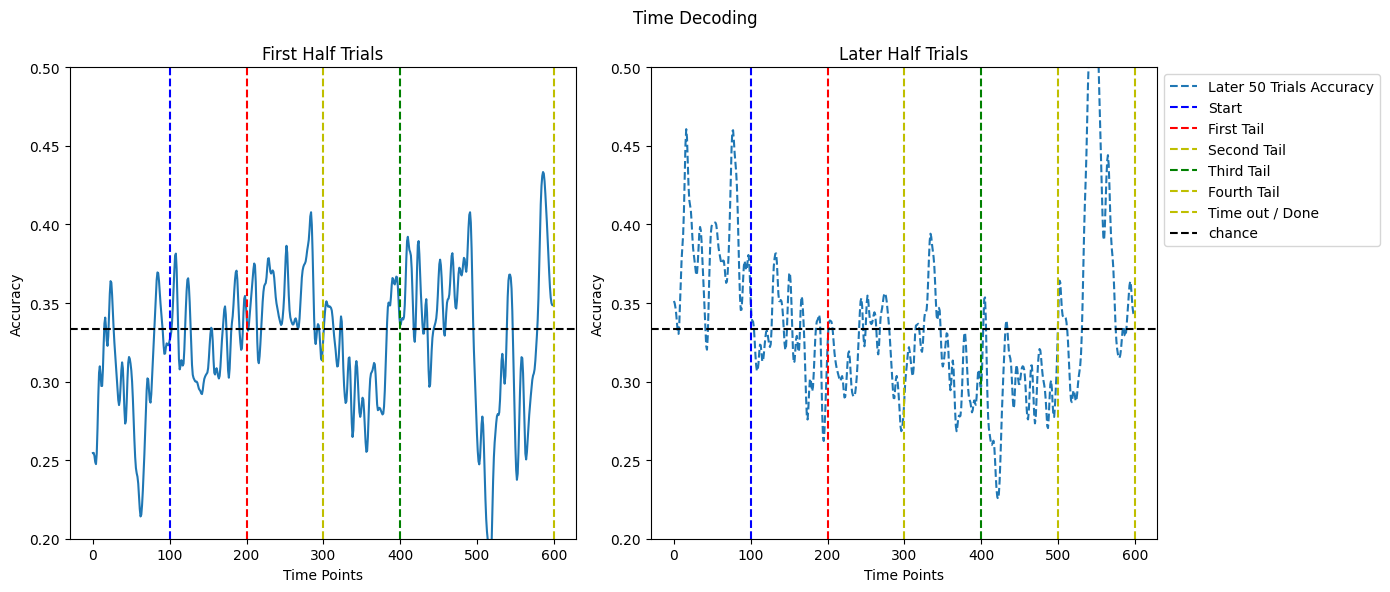

In [47]:
mean_scores_first, mean_scores_later = train_time_decoder(X_combined, y_combined, cv)
plot_time_decoding(mean_scores_first, mean_scores_later, 'Time Decoding')